# **Kaggle Challenge: Pirate Pain Dataset 🏴‍☠️**

This notebook is a modified version of the Lecture 4 (Timeseries Classification) code, adapted for the Kaggle challenge.

**Local Setup:**
1.  Ensure you have a Conda environment with PyTorch (GPU), `pandas`, `sklearn`, and `jupyterlab`.
2.  Place the Kaggle CSVs (`pirate_pain_train.csv`, `pirate_pain_train_labels.csv`, `pirate_pain_test.csv`) in a folder named `data/` in the same directory as this notebook.
3.  To run TensorBoard, open a separate terminal, `conda activate` your environment, `cd` to this folder, and run: `tensorboard --logdir=./tensorboard`

## ⚙️ **1. Setup & Libraries**

In [6]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
from itertools import product

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# --- PyTorch Imports ---
import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# --- Sklearn Imports ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# --- Setup Directories & Device ---
logs_dir = "tensorboard"
os.makedirs("models", exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    # This is a performance optimization for when input sizes don't vary
    torch.backends.cudnn.benchmark = True
    print("\n--- Using GPU (RTX 3070, here we come!) ---")
else:
    device = torch.device("cpu")
    print("\n--- Using CPU ---")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


--- Using GPU (RTX 3070, here we come!) ---
PyTorch version: 2.5.1
Device: cuda


## 🔄 **2. Data Loading & Reshaping**

This is the most critical new step. The data is in a "long" format (one row per timestep), where each `sample_index` is one complete time series. We must:
1.  Define the features we want to use.
2.  Pivot the data to get a 3D tensor of shape `(num_samples, num_timesteps, num_features)`.

In [7]:
# --- 1. Define File Paths and Features ---
DATA_DIR = "data"
X_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train.csv")
Y_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train_labels.csv")
X_TEST_PATH = os.path.join(DATA_DIR, "pirate_pain_test.csv")
SUBMISSION_PATH = os.path.join(DATA_DIR, "sample_submission.csv")

# Define our time-series features
# We'll ignore static features (n_legs, etc.) for our baseline model
JOINT_FEATURES = [f"joint_{i:02d}" for i in range(31)]
PAIN_FEATURES = [f"pain_survey_{i}" for i in range(1, 5)]
FEATURES = JOINT_FEATURES + PAIN_FEATURES

N_FEATURES = len(FEATURES)
N_TIMESTEPS = 160 # Given in the problem description

print(f"Using {N_FEATURES} features: {FEATURES[:3]}... to {FEATURES[-3:]}")

# --- 2. Create the Reshaping Function ---
def reshape_data(df, features_list, n_timesteps):
    """
    Pivots the long-format dataframe into a 3D NumPy array.
    Shape: (n_samples, n_timesteps, n_features)
    """
    # Use pivot to create a (n_samples, n_features * n_timesteps) table
    # This works because the (sample_index, time) pairs are unique
    df_pivot = df.pivot(index='sample_index', columns='time', values=features_list)
    
    # The resulting columns are multi-level (e.g., ('joint_00', 0), ('joint_00', 1)...)
    # We don't need to sort them; pivot already preserves order.
    
    # Get the raw values, which is a 2D array
    # Shape: (n_samples, n_features * n_timesteps)
    data_2d = df_pivot.values
    
    # Get the number of samples
    n_samples = data_2d.shape[0]
    
    # Reshape to (n_samples, n_features, n_timesteps)
    # We shape it this way first because of how .values flattens the pivot table
    data_3d = data_2d.reshape(n_samples, len(features_list), n_timesteps)
    
    # **CRITICAL STEP**: Transpose to match RNN expected input
    # We want (n_samples, n_timesteps, n_features) for batch_first=True
    return data_3d.transpose(0, 2, 1)

# --- 3. Load and Reshape Data ---
print("Loading and reshaping training data...")
X_train_long = pd.read_csv(X_TRAIN_PATH)
X_train_full = reshape_data(X_train_long[X_train_long['sample_index'].isin(X_train_long['sample_index'].unique())], FEATURES, N_TIMESTEPS)

print("Loading and reshaping test data...")
X_test_long = pd.read_csv(X_TEST_PATH)
X_test = reshape_data(X_test_long, FEATURES, N_TIMESTEPS)

# Load labels
y_train_df = pd.read_csv(Y_TRAIN_PATH)
print("\n--- Debugging y_train_df ---")
print(f"Columns found: {y_train_df.columns.tolist()}")
print(y_train_df.head())
print("----------------------------\n")
# We need to sort by sample_index to match X_train_full, which is sorted by pivot
y_train_full_df = y_train_df.sort_values(by='sample_index')
y_train_labels_str = y_train_full_df['label'].values

print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_labels_str shape: {y_train_labels_str.shape}")
print(f"X_test shape: {X_test.shape}")

# Clean up large dataframes to save memory
del X_train_long, X_test_long, y_train_df

Using 35 features: ['joint_00', 'joint_01', 'joint_02']... to ['pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Loading and reshaping training data...
Loading and reshaping test data...

--- Debugging y_train_df ---
Columns found: ['sample_index', 'label']
   sample_index     label
0             0   no_pain
1             1   no_pain
2             2  low_pain
3             3   no_pain
4             4   no_pain
----------------------------

X_train_full shape: (661, 160, 35)
y_train_labels_str shape: (661,)
X_test shape: (1324, 160, 35)


## 🚧 **3. Preprocessing: Split & Scale**

1.  **Encode Labels:** Convert `no_pain`, `low_pain`, `high_pain` to `0`, `1`, `2`.
2.  **Split Data:** Use `StratifiedShuffleSplit` to create a single 80/20 train/validation split. This ensures both sets have the same class proportions.
3.  **Scale Features:** Use `StandardScaler`. We `fit` it *only* on the training data and `transform` all sets (train, val, and test).

In [8]:
# --- 1. Encode Labels ---
LABEL_MAPPING = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
le = LabelEncoder()
le.fit(list(LABEL_MAPPING.keys()))
y_train_full = le.transform(y_train_labels_str)
N_CLASSES = len(LABEL_MAPPING)

print(f"Labels encoded. {N_CLASSES} classes: {LABEL_MAPPING}")

# --- 2. Create Validation Split ---
# We use StratifiedShuffleSplit to maintain class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

for train_idx, val_idx in sss.split(X_train_full, y_train_full):
    X_train_split = X_train_full[train_idx]
    y_train_split = y_train_full[train_idx]
    X_val_split = X_train_full[val_idx]
    y_val_split = y_train_full[val_idx]

print(f"Data split into Train and Validation sets:")
print(f"  X_train_split: {X_train_split.shape}")
print(f"  y_train_split: {y_train_split.shape}")
print(f"  X_val_split:   {X_val_split.shape}")
print(f"  y_val_split:   {y_val_split.shape}")

# --- 3. Scale Features (The "No-Cheating" Rule) ---
scaler = StandardScaler()

# To fit the scaler, we must reshape our 3D data to 2D
# (samples, timesteps, features) -> (samples * timesteps, features)
# We must do this for all sets before transforming

# Reshape train and FIT the scaler
ns, ts, f = X_train_split.shape
X_train_2d = X_train_split.reshape(ns * ts, f)
print(f"Fitting Scaler on X_train_2d shape: {X_train_2d.shape}")
scaler.fit(X_train_2d)

# TRANSFORM train and reshape back to 3D
X_train_scaled_2d = scaler.transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape(ns, ts, f)

# TRANSFORM val and reshape back to 3D
ns_val, ts_val, f_val = X_val_split.shape
X_val_2d = X_val_split.reshape(ns_val * ts_val, f_val)
X_val_scaled_2d = scaler.transform(X_val_2d)
X_val_scaled = X_val_scaled_2d.reshape(ns_val, ts_val, f_val)

# TRANSFORM test and reshape back to 3D (for final submission)
ns_test, ts_test, f_test = X_test.shape
X_test_2d = X_test.reshape(ns_test * ts_test, f_test)
X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled = X_test_scaled_2d.reshape(ns_test, ts_test, f_test)

print("Scaling complete.")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_val_scaled:   {X_val_scaled.shape}")
print(f"  X_test_scaled:  {X_test_scaled.shape}")

# Clean up 2D arrays
del X_train_2d, X_val_2d, X_test_2d, X_train_scaled_2d, X_val_scaled_2d, X_test_scaled_2d

Labels encoded. 3 classes: {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
Data split into Train and Validation sets:
  X_train_split: (528, 160, 35)
  y_train_split: (528,)
  X_val_split:   (133, 160, 35)
  y_val_split:   (133,)
Fitting Scaler on X_train_2d shape: (84480, 35)
Scaling complete.
  X_train_scaled: (528, 160, 35)
  X_val_scaled:   (133, 160, 35)
  X_test_scaled:  (1324, 160, 35)


## 🚚 **4. PyTorch DataLoaders**

This section is identical to Lecture 4. We wrap our NumPy arrays in `TensorDataset` and `DataLoader` to efficiently feed batches to the GPU.

In [9]:
# --- 1. Convert to Tensors ---
# We use .float() for features and .long() for classification labels
train_features = torch.from_numpy(X_train_scaled).float()
train_targets = torch.from_numpy(y_train_split).long()

val_features = torch.from_numpy(X_val_scaled).float()
val_targets = torch.from_numpy(y_val_split).long()

test_features = torch.from_numpy(X_test_scaled).float()

# --- 2. Create TensorDatasets ---
train_ds = TensorDataset(train_features, train_targets)
val_ds = TensorDataset(val_features, val_targets)
test_ds = TensorDataset(test_features) # Test set has no labels

# --- 3. Define make_loader function (from Lecture 4) ---
BATCH_SIZE = 128 # You can tune this

def make_loader(ds, batch_size, shuffle, drop_last):
    # --- START FIX ---
    # On Windows, num_workers > 0 can cause major bottlenecks.
    # We will set it to 0 to force data loading in the main process.
    num_workers = 0 
    # --- END FIX ---
    
    print(f"Creating DataLoader with batch_size={batch_size} and num_workers={num_workers} (Windows-friendly)")

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        # prefetch_factor is only useful for num_workers > 0
        prefetch_factor=None,
    )

# --- 4. Create DataLoaders ---
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
# Test loader will be made in the submission step

# Check one batch
for xb, yb in train_loader:
    print("\n--- Checking one batch --- ")
    print("Features batch shape:", xb.shape) # (BATCH_SIZE, 180, 35)
    print("Labels batch shape:", yb.shape)   # (BATCH_SIZE)
    break # Stop after getting one batch

Creating DataLoader with batch_size=128 and num_workers=0 (Windows-friendly)
Creating DataLoader with batch_size=128 and num_workers=0 (Windows-friendly)

--- Checking one batch --- 
Features batch shape: torch.Size([128, 160, 35])
Labels batch shape: torch.Size([128])


## 🛠️ **5. Model & Training Engine (From Lecture 4)**

This is the "treasure map." These classes and functions are copied directly from Lecture 4, as they are perfect for this problem.

-   `RecurrentClassifier`: Our flexible model (RNN, LSTM, GRU).
-   `fit`: The main training loop with early stopping.

In [10]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.
    """

    output_shapes = {}
    hooks = []

    def get_hook(name):
        def hook(module, input, output):
            if isinstance(output, tuple):
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)
                shape2[1] = -1
                output_shapes[name] = f"[{shape1}, {shape2}]"
            else:
                shape = list(output.shape)
                shape[0] = -1
                output_shapes[name] = f"{shape}"
        return hook

    try:
        device_summary = next(model.parameters()).device
    except StopIteration:
        device_summary = torch.device("cpu")

    dummy_input = torch.randn(1, *input_size).to(device_summary)

    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            for h in hooks:
                h.remove()
            return

    for h in hooks:
        h.remove()

    print("-" * 79)
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    for name, module in model.named_children():
        if name in output_shapes:
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [11]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU) from Lecture 4.
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """
        rnn_out, hidden = self.rnn(x)

        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden_to_classify = hidden[-1]

        logits = self.classifier(hidden_to_classify)
        return logits

In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }
    
    model_path = f"models/{experiment_name}_best_model.pt"

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"--- Starting Training: {experiment_name} ---")
    print(f"Will train for {epochs} epochs with patience={patience} monitoring {evaluation_metric}")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        print(f"Restoring best model from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        model.load_state_dict(torch.load(model_path))

    if patience == 0:
        print("Training complete. Saving final model.")
        torch.save(model.state_dict(), model_path.replace("_best_model.pt", "_final_model.pt"))

    if writer is not None:
        writer.close()
    
    print(f"--- Finished Training: {experiment_name} ---")
    return model, training_history, best_epoch if 'best_epoch' in locals() else epochs

## 🧪 **6. Experiment 1: Baseline Model (GRU)**

Let's start with a strong baseline from Lecture 4: a 2-layer GRU. We'll train it on our split data and see what F1 score we get on the validation set. This is our starting point.


--- Building GRU model (Bidirectional=False) ---
Compiling model with torch.compile() for a speed boost...
-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
Total params: 0
Trainable params: 0
Non-trainable params: 0
-------------------------------------------------------------------------------
--- Starting Training: GRU_H128_L2_BFalse_D0.3_1762551528 ---
Will train for 200 epochs with patience=30 monitoring val_f1
Epoch   1/200 | Train: Loss=1.0330, F1=0.5125 | Val: Loss=0.9406, F1=0.7337
Epoch   5/200 | Train: Loss=0.5995, F1=0.7489 | Val: Loss=0.5130, F1=0.7444
Epoch  10/200 | Train: Loss=0.4864, F1=0.7695 | Val: Loss=0.4683, F1=0.7854
Epoch  15/200 | Train: Loss=0.3739, F1=0.8276 | Val: Loss=0.5066, F1=0.7978
Epoch  20/200 | Train: Loss=0.2648, F1=0.9033 | Val: Loss=0.5135, F1=0.8174
Epoch  25/200 | Train: Loss=0.1805, F1=0.9358 | Val: Loss=0.4797, F1=0.8488
Epoch  30/200 | Tra

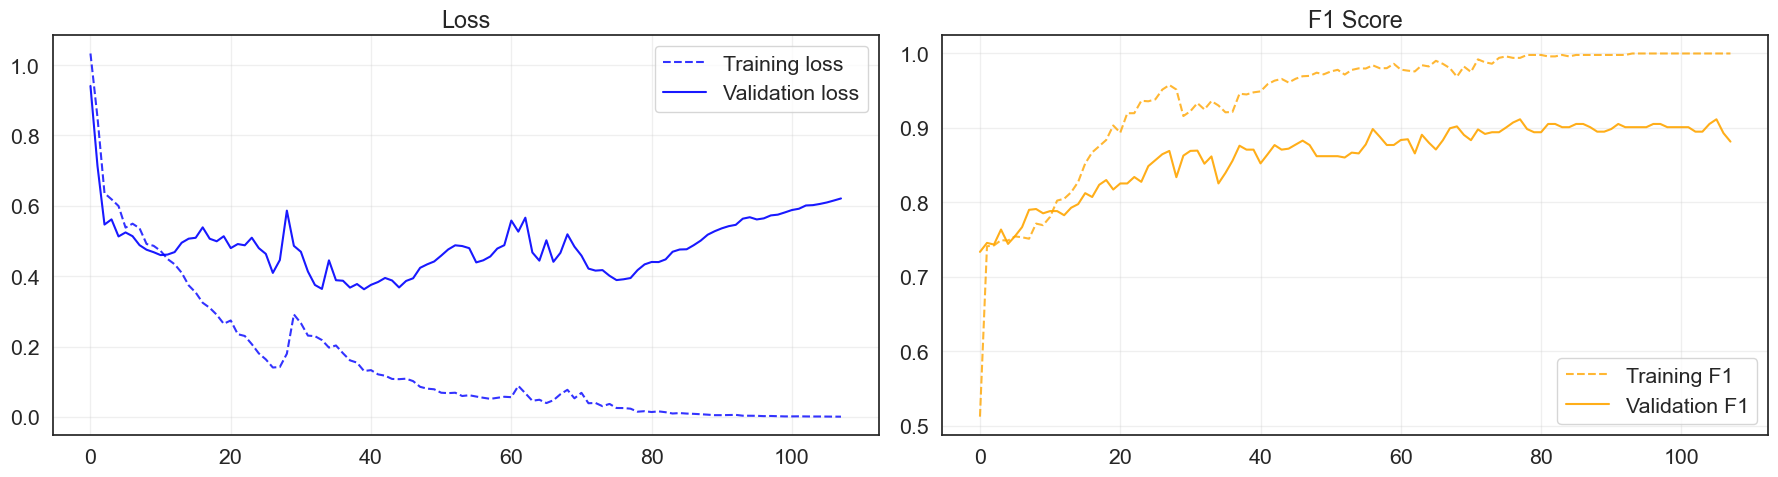

In [13]:
# --- 1. Define Hyperparameters ---

# Architecture
import time


INPUT_SIZE = N_FEATURES      # 35 features
SEQ_LEN = N_TIMESTEPS        # 160 timesteps
HIDDEN_SIZE = 128          # You can tune this
HIDDEN_LAYERS = 2          # You can tune this
MODEL_TYPE = 'GRU'         # 'RNN', 'LSTM', or 'GRU'
BIDIRECTIONAL = False      # You can tune this

# Training
LEARNING_RATE = 1e-3       # You can tune this
EPOCHS = 200               # Max epochs
PATIENCE = 30              # Early stopping patience

# Regularisation
DROPOUT_RATE = 0.3         # You can tune this
L2_LAMBDA = 0              # You can tune this

# --- 2. Create Model, Loss, Optimizer ---
print(f"\n--- Building {MODEL_TYPE} model (Bidirectional={BIDIRECTIONAL}) ---")

baseline_model = RecurrentClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=N_CLASSES,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=MODEL_TYPE
).to(device)

# Compile the model (for PyTorch 2.0+ on your 3070)
if torch.__version__[0] >= "2":
    print("Compiling model with torch.compile() for a speed boost...")
    baseline_model = torch.compile(baseline_model)

recurrent_summary(baseline_model, input_size=(SEQ_LEN, INPUT_SIZE))

# Loss function (CrossEntropy handles softmax internally)
criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW is Adam with proper L2 weight decay)
optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Mixed precision scaler for faster training on RTX cards
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# TensorBoard Writer
timestamp = int(time.time()) # Get current time as a number
experiment_name = f"{MODEL_TYPE}_H{HIDDEN_SIZE}_L{HIDDEN_LAYERS}_B{BIDIRECTIONAL}_D{DROPOUT_RATE}_{timestamp}"
writer = SummaryWriter(f"{logs_dir}/{experiment_name}")

# --- 3. Run Training ---
baseline_model, history, best_epoch = fit(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5, # Print update every 5 epochs
    experiment_name=experiment_name,
    patience=PATIENCE
)

# --- 4. Plot History ---
print("\n--- Plotting Training History ---")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Training loss', alpha=0.8, color='blue', linestyle='--')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='blue')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot F1 Score
ax2.plot(history['train_f1'], label='Training F1', alpha=0.8, color='orange', linestyle='--')
ax2.plot(history['val_f1'], label='Validation F1', alpha=0.9, color='orange')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 📬 **7. Create Submission**

Now we follow the plan:
1.  Create a **new, full training set** (train + val).
2.  Re-scale the data and create a `full_train_loader`.
3.  Instantiate a **fresh copy** of our best model (with the same hyperparameters).
4.  Train it on the **full dataset** for the `best_epoch` we found in the previous step (this prevents overfitting).
5.  Create a `test_loader`.
6.  Generate predictions on the test set.
7.  Save to `submission.csv`.

In [14]:
# --- 1. & 2. Create Full Training Set & Loader ---
print("\n--- Preparing full dataset for final training ---")
# We already have the full data: X_train_full, y_train_full

# We must re-scale the *entire* training set
scaler_final = StandardScaler()

ns, ts, f = X_train_full.shape
X_train_full_2d = X_train_full.reshape(ns * ts, f)

print(f"Fitting FINAL Scaler on X_train_full_2d shape: {X_train_full_2d.shape}")
scaler_final.fit(X_train_full_2d)

# Transform full train set
X_train_full_scaled_2d = scaler_final.transform(X_train_full_2d)
X_train_full_scaled = X_train_full_scaled_2d.reshape(ns, ts, f)

# Transform test set *using this new final scaler*
# This is the correct way, as our model will be trained on this new scaling
ns_test, ts_test, f_test = X_test.shape
X_test_2d = X_test.reshape(ns_test * ts_test, f_test)
X_test_final_scaled_2d = scaler_final.transform(X_test_2d)
X_test_final_scaled = X_test_final_scaled_2d.reshape(ns_test, ts_test, f_test)

print("Final scaling complete.")

# Create final DataLoaders
full_train_features = torch.from_numpy(X_train_full_scaled).float()
full_train_targets = torch.from_numpy(y_train_full).long()
final_test_features = torch.from_numpy(X_test_final_scaled).float()

full_train_ds = TensorDataset(full_train_features, full_train_targets)
final_test_ds = TensorDataset(final_test_features)

full_train_loader = make_loader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = make_loader(final_test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# --- 3. Instantiate Fresh Model ---
print(f"\n--- Building FINAL {MODEL_TYPE} model for submission ---")
final_model = RecurrentClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=N_CLASSES,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=MODEL_TYPE
).to(device)

if torch.__version__[0] >= "2":
    print("Compiling final model...")
    final_model = torch.compile(final_model)

final_optimizer = torch.optim.AdamW(final_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
final_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# --- 4. Train on Full Dataset ---
# We train for the 'best_epoch' found during validation.
# This is a common strategy to get the best of both worlds:
# - We use all data (train+val) for more robust training.
# - We use the 'best_epoch' to prevent overfitting.
print(f"Training final model for {best_epoch} epochs on ALL data...")

final_model.train() # Set to train mode
for epoch in range(1, best_epoch + 1):
    # We only need the training loop now
    train_loss, train_f1 = train_one_epoch(
        final_model, full_train_loader, criterion, final_optimizer, final_scaler, device, L2_LAMBDA
    )
    if epoch % 5 == 0 or epoch == 1:
        print(f"Final Training Epoch {epoch:3d}/{best_epoch} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f}")

print("Final training complete.")

# --- 5. & 6. Generate Predictions ---
print("\n--- Generating predictions on test set ---")
final_model.eval() # Set to evaluation mode
all_predictions = []

with torch.no_grad():
    for (inputs,) in test_loader: # Note the comma: test_loader only yields inputs
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = final_model(inputs)
            preds = logits.argmax(dim=1)
            all_predictions.append(preds.cpu().numpy())

all_predictions = np.concatenate(all_predictions)

# Convert numeric predictions back to string labels
predicted_labels = le.inverse_transform(all_predictions)

print(f"Generated {len(predicted_labels)} predictions.")

# --- 7. Save Submission File ---
submission_df = pd.read_csv(SUBMISSION_PATH)

# Make sure the sample_index in submission matches our predictions
# We must load the original test set to get the unique sample_index order
# that our `reshape_data` function used.
X_test_long = pd.read_csv(X_TEST_PATH)
test_sample_indices = X_test_long['sample_index'].unique()

submission_df = pd.DataFrame({
    'sample_index': test_sample_indices,
    'label': predicted_labels
})
 # 1. Define and create the submissions directory
SUBMISSIONS_DIR = "submissions"
os.makedirs(SUBMISSIONS_DIR, exist_ok=True)
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{x:03d}")
submission_filename = f"submission_{experiment_name}.csv"
submission_df.to_csv(os.path.join(SUBMISSIONS_DIR, submission_filename), index=False)

print(f"\nSuccessfully saved {submission_filename}!")
print(submission_df.head())

# Clean up memory
del final_model, full_train_loader, test_loader, full_train_features, final_test_features


--- Preparing full dataset for final training ---
Fitting FINAL Scaler on X_train_full_2d shape: (105760, 35)
Final scaling complete.
Creating DataLoader with batch_size=128 and num_workers=0 (Windows-friendly)
Creating DataLoader with batch_size=128 and num_workers=0 (Windows-friendly)

--- Building FINAL GRU model for submission ---
Compiling final model...
Training final model for 78 epochs on ALL data...
Final Training Epoch   1/78 | Train: Loss=0.9289, F1=0.7001
Final Training Epoch   5/78 | Train: Loss=0.5209, F1=0.7549
Final Training Epoch  10/78 | Train: Loss=0.4245, F1=0.8166
Final Training Epoch  15/78 | Train: Loss=0.2604, F1=0.8900
Final Training Epoch  20/78 | Train: Loss=0.1769, F1=0.9339
Final Training Epoch  25/78 | Train: Loss=0.1107, F1=0.9539
Final Training Epoch  30/78 | Train: Loss=0.0775, F1=0.9793
Final Training Epoch  35/78 | Train: Loss=0.0729, F1=0.9777
Final Training Epoch  40/78 | Train: Loss=0.1136, F1=0.9593
Final Training Epoch  45/78 | Train: Loss=0.058